In [20]:
import torch
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
from typing import Callable, Tuple, List

In [21]:
def rosenbrock_torch(
        z: torch.Tensor
) -> torch.Tensor:
    
    """
        ローゼンブロック関数 f(z0, z1) = (1 - z0)^2 + 100(z1 - z0^2)^2
    """
    
    # z[0] が z0, z[1] が z1
    return (1 - z[0])**2 + 100 * (z[1] - z[0]**2)**2

In [ ]:
def get_grad_hess(
        z: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    
    """
        指定された点(z)における勾配(g)とヘッセ行列(H)を計算する。
    """
    
    dtype = z.dtype
    device = z.device

    z0 = z[0]
    z1 = z[1]

    # grad
    g0 = -2*(1 - z0) - 400*z0*(z1 - z0**2)
    g1 = 200*(z1 - z0**2)
    # ベクトルに変換
    g = torch.tensor([g0, g1], dtype=dtype, device=device)

    # hessian
    H00 = 1200.0 * z0**2 - 400*z1 + 2.0
    H01 = -400.0 * z0
    H10 = -400.0 * z0
    H11 = torch.tensor(200.0, dtype=dtype, device=device)
    # 行列に変換
    H = torch.tensor(
        [[H00, H01],
        [H10, H11]],
        dtype=dtype, device=device)
    
    return g, H

In [23]:
def newton_step(
        g: np.ndarray, 
        H: np.ndarray
) -> np.ndarray:
    
    """
        ニュートン法
        s = -H^-1 * g を計算する
    """
    
    # H * s = -g を解く
    # 逆行列を直接計算するより高速
    try:
        s = np.linalg.solve(H, -g)
    except np.linalg.LinAlgError:
        # もし逆行列を計算できない場合，勾配法で代用
        s = -0.01 * g
    
        
    return s

In [24]:
def solve_cubic_newton_step(
        g: np.ndarray,
        H: np.ndarray,
        L: float = 1.0
) -> np.ndarray:
    
    """
        三次正則化ニュートン法
        s = -(H + λI)^-1 * g を計算する
        
        λ ≈ sqrt( (L/2) * ||g|| )で計算する
    """

    # 勾配のノルムを計算
    g_norm = np.linalg.norm(g)

    # λ_k ≈ sqrt( (L/2) * ||g|| )
    Lambda = np.sqrt((L / 2.0) * g_norm)

    # ヘッセ行列にλIを加える
    # np.identity(H.shape[0])は単位行列
    H_reg = H + Lambda * np.identity(H.shape[0])

    # s = -(H + λI)^-1 * g を解く
    try:
        s = -np.linalg.solve(H_reg, g)
    except np.linalg.LinAlgError:
        s = -0.01 * g
    
    return s

In [ ]:
def run_optimizer(
    func: Callable[[torch.Tensor], torch.Tensor], 
    z_init: torch.Tensor, 
    method: str, 
    L: float = 1.0, 
    iterations: int = 20
) -> Tuple[np.ndarray, List[float]]:
    
    """
        指定されたアルゴリズムで最適化を実行する
    """
    
    print(f"\n--- {method.upper()} を実行 ---")
    
    # z_initをzにコピー
    z = z_init.clone()
    
    # 軌跡を保存するリスト
    path_history = []
    f_history = []
    
    for k in range(iterations):
        # 現在地をnumpyに変換して保存
        path_history.append(
            z.detach() # 前のステップの計算グラフを切り離す
            .numpy()   # Pytorch -> NumPyに変換
            .copy()    # ポインタではなく値を追加する
        )
        
        # 1. 勾配(g)とヘッセ行列(H)を計算
        z_tensor = z.clone().detach()
        g, H = get_grad_hess(z_tensor)
        
        # 現在の間数値を計算
        # tensor型なので.item()で数値を取り出す
        f_val = func(z_tensor).item()
        f_history.append(f_val)
        
        # 2. gとHをNumPyに変換
        #    (SciPyやNumPyのソルバーと連携するため)
        g_np = g.detach().numpy()
        H_np = H.detach().numpy()
        
        # 収束判定
        # 勾配ベクトルのL2ノルムを計算し1e-6が小さければ最小値に到達したとみなす
        if np.linalg.norm(g_np) < 1e-6:
            print(f'step={k}で収束')
            break

        # 3. アルゴリズムに応じて次のステップ s を計算
        # いずれも更新量を求める関数に注意
        if method == 'newton':
            s_np = newton_step(g_np, H_np)
        elif method == 'cubic_newton':
            s_np = solve_cubic_newton_step(g_np, H_np, L)
        else:
            raise ValueError("optim error")

        # 4. sをPyTorch Tensorに戻し、パラメータ z を更新
        s = torch.tensor(s_np, dtype=torch.float32)
        # z_{k+1} = z_k + s
        z = z + s 
        
        if k < 10 or k % 5 == 0:
             print(f"ステップ {k:02d}: f(z) = {f_val: 10.4f}, z = [{z[0]:.4f}, {z[1]:.4f}], ||g|| = {np.linalg.norm(g_np):.4f}")

    # 最終地点を追加
    path_history.append(z.detach().numpy().copy())
    f_history.append(func(z).item())
    
    return np.array(path_history), f_history

In [26]:
def plot_results(path_newton, path_cubic, f_hist_newton, f_hist_cubic):
    """
    最適化の軌跡と関数値の減少をプロットする
    """
    
    # ローゼンブロック関数の等高線
    x = np.linspace(-2, 2, 400)
    y = np.linspace(-1, 3, 400)
    X, Y = np.meshgrid(x, y)
    Z = (1 - X)**2 + 100 * (Y - X**2)**2
    
    plt.figure(figsize=(18, 8))
    
    # --- プロット1: 最適化の軌跡 ---
    plt.subplot(1, 2, 1)
    # 等高線を対数スケールでプロット
    plt.contour(X, Y, Z, levels=np.logspace(-0.5, 3.5, 20), cmap='viridis_r')
    plt.plot(path_newton[:, 0], path_newton[:, 1], 'o-', label=f"Newton ({len(path_newton)-1} steps)", color='red')
    plt.plot(path_cubic[:, 0], path_cubic[:, 1], 'o-', label=f"Cubic Newton ({len(path_cubic)-1} steps)", color='blue')
    
    # 最小値の点
    plt.plot(1, 1, 'x', color='black', markersize=15, label='Minimum (1, 1)')
    plt.title('Optimization Path on Rosenbrock Function')
    plt.xlabel('$z_0$')
    plt.ylabel('$z_1$')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # --- プロット2: 関数値の減少 ---
    plt.subplot(1, 2, 2)
    plt.plot(f_hist_newton, 'o-', label='Newton', color='red')
    plt.plot(f_hist_cubic, 'o-', label='Cubic Newton', color='blue')
    plt.yscale('log')
    plt.title('Function Value $f(z)$ (Log Scale)')
    plt.xlabel('Step')
    plt.ylabel('$f(z)$')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [27]:
# スタート地点
# z_start = torch.tensor([-1.5, 2.5], dtype=torch.float32)
# z_start = torch.tensor([-1.2, 1.0], dtype=torch.float32)
# z_start = torch.tensor([0.0, 0.0], dtype=torch.float32)
z_start = torch.tensor([2.0, 2.0], dtype=torch.float32)


--- NEWTON を実行 ---
ステップ 00: f(z) =   401.0000, z = [1.9975, 3.9900], ||g|| = 1651.1826
ステップ 01: f(z) =     0.9950, z = [1.0013, 0.0101], ||g|| = 2.0000
ステップ 02: f(z) =    98.4944, z = [1.0013, 1.0026], ||g|| = 444.2952
ステップ 03: f(z) =     0.0000, z = [1.0000, 1.0000], ||g|| = 0.0025
ステップ 04: f(z) =     0.0000, z = [1.0000, 1.0000], ||g|| = 0.0007
step=5で収束

--- CUBIC_NEWTON を実行 ---
ステップ 00: f(z) =   401.0000, z = [1.8353, 3.1728], ||g|| = 1651.1826
ステップ 01: f(z) =     4.5241, z = [1.7973, 3.2265], ||g|| = 150.4506
ステップ 02: f(z) =     0.6371, z = [1.7299, 2.9898], ||g|| = 4.3743
ステップ 03: f(z) =     0.5336, z = [1.6564, 2.7398], ||g|| = 3.4369
ステップ 04: f(z) =     0.4322, z = [1.5902, 2.5257], ||g|| = 3.8856
ステップ 05: f(z) =     0.3491, z = [1.5195, 2.3052], ||g|| = 3.0733
ステップ 06: f(z) =     0.2712, z = [1.4559, 2.1169], ||g|| = 3.3258
ステップ 07: f(z) =     0.2087, z = [1.3897, 1.9281], ||g|| = 2.6175
ステップ 08: f(z) =     0.1530, z = [1.3308, 1.7684], ||g|| = 2.6965
ステップ 09: f(z) =     0.11

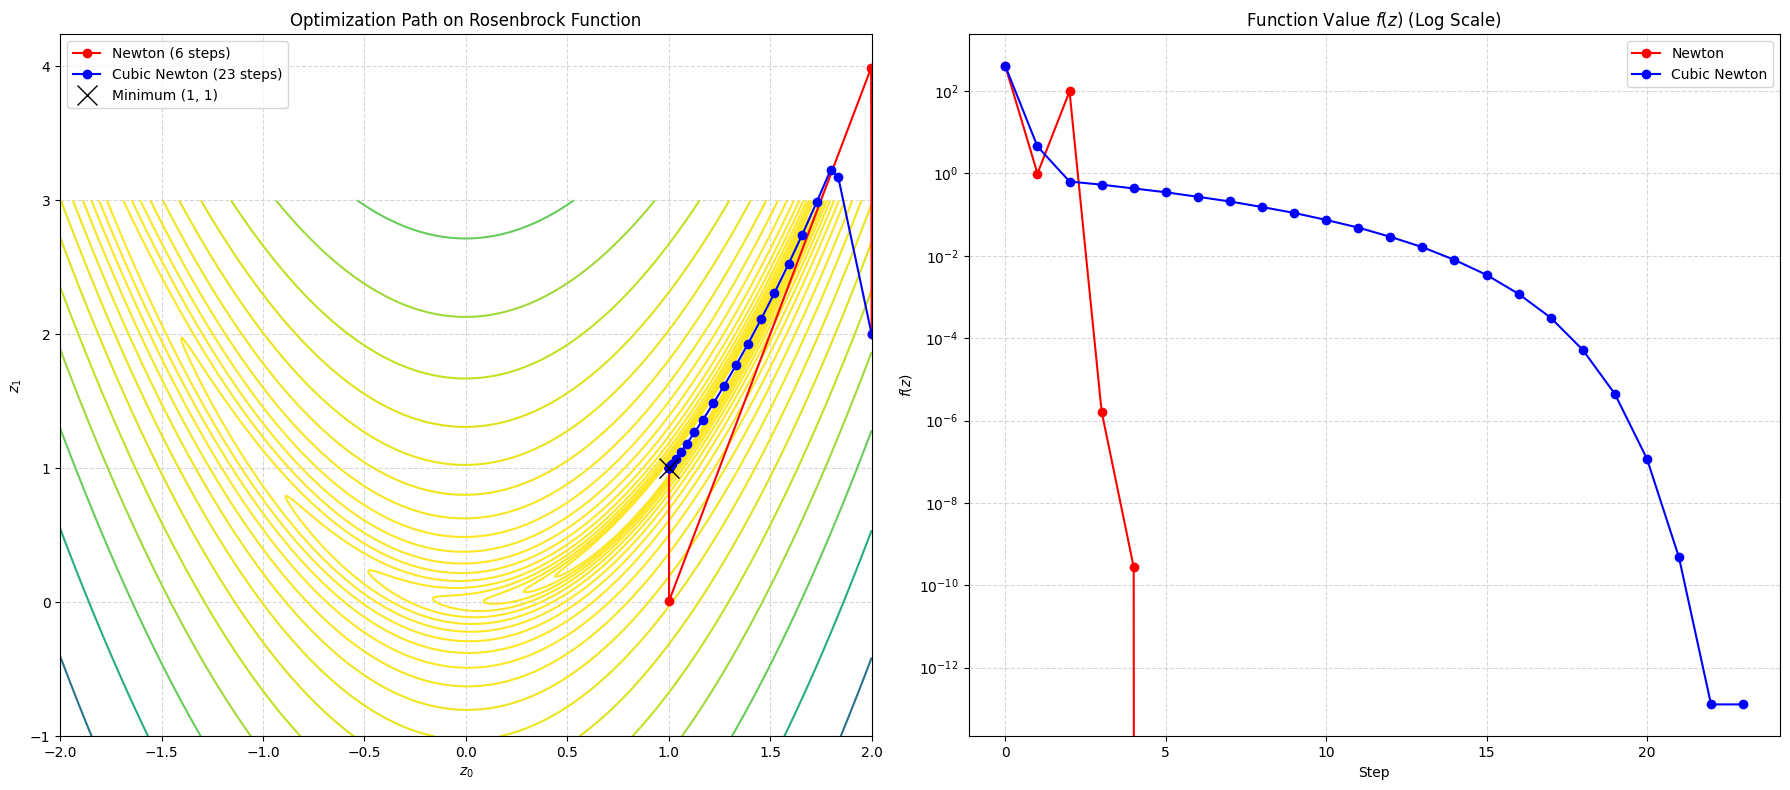

In [28]:
ITERATION: int = 1000

# ニュートン法
path_n, f_n = run_optimizer(
        func=rosenbrock_torch, 
        z_init=z_start, 
        method='newton', 
        iterations=ITERATION
    )

# 三次正則化ニュートン法
path_c, f_c = run_optimizer(
        func=rosenbrock_torch, 
        z_init=z_start, 
        method='cubic_newton', 
        iterations=ITERATION
    )

plot_results(path_n, path_c, f_n, f_c)